# Physics Informed Neural Networks (PINN): Tutorial
> For the Fall 2024 course: *Machine Learning in Physics*<br>
> Created: Aug. 14, 2024 Harrison B. Prosper

## Introduction
Most differential equations cannot be solved exactly. Therefore, over the centuries many numerical methods have been devised to solve these equations approximately. A relatively recent numerical approach called **physics-informed neural networks** (PINN) formulates the solution of a differential equation as an optimization problem in which the approximate solution is modeled using one or more neural networks. For an excellent introduction, I recommend the lectures by Bob Moseley (see, for example, https://www.youtube.com/watch?v=IDIv92Z6Qvc). For a thorough review, see for example, https://doi.org/10.48550/arXiv.2201.05624. 
Physics-informed neural network is clearly a misnomer. Why? Because this very powerful idea for numerically solving a differential equation can be applied to *any* differential equation, not only the ones in physics! The approach is feasible because the derivatives that enter the objective function can be computed *exactly* using **automatic differentiation**.

In this tutorial we consider the example presented by Bob Moseley in the lecture cited above, namely the solution $u(t) \in \mathbb{R}$, $t \in \mathbb{R}^+$, of the ordinary differential equation (ODE)
\begin{align}
   \frac{d^2 u}{dt^2} + 2 \lambda \frac{d u}{ dt } + \omega_0^2 u = 0,
\end{align}
describing a 1D **damped harmomic oscillator**, where 
\begin{align}
    \lambda & = \frac{\mu}{m} \quad\text{and}\\
    \omega_0 & = \sqrt{\frac{k}{m}}
\end{align}
are the characteristic decay rate of the oscillation amplitude and the characteristic frequency, respectively. (In Bob Moseley's lecture $\lambda = \delta$.) The quantity $m$ is the mass, $k$ the spring constant and $\mu$ the coefficient of kinetic friction. 

### Exact Solution
It is almost always a good idea to try to simplify a differential equation before solving it. We can simplify the ODE by dividing throughout by $\omega_0^2$ and defining the dimensionless quantities $z = \omega_0 \, t$ and $\alpha = \lambda /\omega_0 $. With these changes the ODE becomes
\begin{align}
  \frac{d^2 u}{d z^2}  +  2 \alpha \frac{d u}{dz} + u = 0 ,
\end{align}
which shows that the damped harmonic oscillator is governed by a single parameter $\alpha$. To obtain a particular solution of the equation we must specify initial conditions
\begin{align}
    u(0) & = u_0, \\
    \left. \frac{d u}{dz} \right|_{z=0} & = d_0 . 
\end{align}
Since this is a linear equation, we can try a solution of the form
\begin{align}
    u(z) & = A \exp(i q z + \phi),
\end{align}
where $A$ and $\phi$ are constants to be determined by the initial conditions and where it is understood that we'll take the real part of $u(z)$ at the end. One finds $q = i \alpha \pm \sqrt{1 - \alpha^2}$. Taking the positive value of $\sqrt{1 - \alpha^2}$ and restricting to the condition $\alpha < 1$ the exact solution is given by
\begin{align}
    u(z) & = A \exp(-\alpha z) \, \cos\left(z \sqrt{1-\alpha^2} + \phi\right)  \quad\text{and} \\
    \phi & = \arctan\left(-\frac{(\alpha + d_0 / u_0)}{\sqrt{1 - \alpha^2}}\right), \quad A = \frac{u_0}{\cos\phi} .
\end{align}
In terms of the original parameters, 
 the exact solution of the ODE for $\alpha < 1$, that is, $\omega_0 > \lambda$, is 
\begin{align}
    u(t) & = A \exp(-\lambda t) \, \cos(\omega \, t + \phi), \quad\text{with } \omega = \sqrt{\omega_0^2 - \lambda^2} \quad\text{and} \\
    \phi & = \arctan(-(\lambda + d_0 / u_0) \, / \, \omega), \quad A = u_0 \, / \, \cos\phi , 
\end{align}
with $d_0$ redefined to be $d_0 = du(0) / dt$.

## Physics-Informed Neural Networks
Automatic differentiation is the key technology that has enabled the use of increasingly complex models in contemporary machine learning. The same technology can be used to compute derivatives with respect to the inputs of a model. However, when the computation graph is extended to incorporate such derivatives this can lead to an explosion in the size of the graph, which makes solving differential equations through this method considerably slower than algorithms that use finite differences. But if we condition the solution on the initial conditions $u_0$ and $d_0$ the high cost of finding the solutions using stochastic gradient descent for some subset of initial conditions  is *amortized* over the subsequent rapid application of the PINN for any initial condition within that subset. IN effect, the PINN approach can be used to generate an *infinite* number of solutions indexed by the parameters that define the initial conditions. In a finite-difference calculation, a different calculation is needed for each set of initial (or boundary) conditions. A PINN conditioned on the initial conditions is sometimes called a **conditioned PINN** (C-PINN).  One of the nice features of PINNs is that their solutions can be checked at a few selected parameter points by comparing PINN solutions with solutions obtained using finite-difference methods.

The PINN approach applied to the damped harmonic oscillator entails solving the differential equation by minimizing the following empirical risk, or objective, function
\begin{align}
    O(\theta) & = \frac{1}{N} \sum_{i=1}^N \left(  \frac{d^2u_i}{dz_i^2} + 2 \alpha \frac{du_i}{dz_i} + u_i \right)^2, \quad\quad
    u_i  \equiv u(z_i) .
\end{align}
The $z_i$ are called **collocation points**. In the standard PINN approach, additional terms are added to incorporate the initial and/or boundary conditions and any additional data at hand. But in this tutorial, we have no additional data and we choose to incorporate the initial conditions explicitly using the *ansatz*
\begin{align}
    u(z)  & = \frac{u_0 + z \, d_0 + z^2 \, g(z, u_0, d_0, \alpha; \theta)}{1+z^2} ,
\end{align}
where $g(z, u_0, d_0, \alpha; \theta)$ is a deep neural network with free parameters $\theta$. This ansatz has the property that $u(z) \rightarrow g(z,\cdots)$ and $du/dz \rightarrow dg(z,\cdots)/dz$ as $z \rightarrow \infty$. 
Defining $x = (z, u_0, d_0, \alpha)$, our goal is to find a *continuous* set of solutions in the domain $$x \in [0, 20] \otimes [-1, 1] \otimes [-2, 2] \otimes [0, 0.5] \subset \mathbb{R}^4.$$

In [1]:
# standard system modules
import os, sys
sys.path.append('../../python')

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# needed to generate Sobol sequences of points (quasi-random sampling)
from scipy.stats import qmc

# a simple time left function.
# to monitor the training do
# python monitor_losses.py losses.csv
from lossmonitor import TimeLeft

# update fonts
FONTSIZE = 12
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {str(device):4s}')

Available device: cpu 


## Exact solution
\begin{align}
    u(z) & = A \exp(-\alpha z) \, \cos\left(z \sqrt{1-\alpha^2} + \phi\right)  \quad\text{and} \\
    \phi & = \arctan\left(-\frac{(\alpha + d_0 / u_0)}{\sqrt{1 - \alpha^2}}\right), \quad A = \frac{u_0}{\cos\phi} .
\end{align}

In [3]:
def exact_solution(z, u0, d0, alpha):
    assert alpha > 0
    assert alpha < 1
    a = np.sqrt(1 - alpha**2)
    phi = np.arctan(-(alpha + d0/u0)/a)
    A = u0 / np.cos(phi)
    u = A * torch.exp(-alpha*z) * torch.cos(a*z + phi)
    return u

## Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of the fitted model.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

## Generate data
Here we generate a quasi-random set of points $x = (z, u_0, d_0, \alpha) \in S \subset \mathbb{R}^4$. Quasi-random sampling disributes points more evenly than uniform random sampling.

In [4]:
def sobol_sequence(D, P, lower, upper):
    # D: dimension of input space
    # P: number of points = 2^P
    
    # generate 2^P points in D-dimensional unit hypercube
    sampler= qmc.Sobol(d=D, scramble=True)
    sample = sampler.random_base2(m=P)

    # scale to desired size of hyperrectangle
    sample = qmc.scale(sample, lower, upper)

    # convert to torch tensor of float32
    sample = torch.Tensor(sample)
    return sample

# -----------------------------------------------------------
# CONSTANTS
# -----------------------------------------------------------
LOSS_FILE     = 'losses.csv'   # average losses saved here
PARAMS_FILE   = 'model.pth'    # model parameters
PLOT_FILE     = 'results.png'
TIMELEFT_FILE = 'timeleft.txt' # time left to training completion

# define domain of C-PINN
#           z,  u0,  d0, alpha
LOWER = [ 0.0,-1.0,-2.0, 0.0]
UPPER = [20.0, 1.0, 2.0, 0.5]
SCALE = [20.0, 1.0, 2.0, 1.0]    # See Solution class below

# -----------------------------------------------------------
# DATA
# -----------------------------------------------------------
# we'll be computing du/dx so we need to alert PyTorch of this.
X = sobol_sequence(len(LOWER), 18, LOWER, UPPER).requires_grad_(True).to(device)

X.shape

torch.Size([262144, 4])

In [15]:
ntrain = min(250000, len(X))
nvalid =   5000

i = 0; j= i + ntrain
train_X = X[i:j]

i += ntrain; j = i + nvalid
valid_X = X[i:j]

i += nvalid;
test_X = X[i:]

train_X.shape, valid_X.shape, test_X.shape

(torch.Size([250000, 4]), torch.Size([5000, 4]), torch.Size([7144, 4]))

## Define a fully-connected neural network

### $\texttt{SiLU}(x)$

$\text{silu}(x) = x \, \sigma(x), \text{where } \sigma(x) \text{ is the logistic sigmoid.}$

In [6]:
class FCN(nn.Module):
    def __init__(self, n_input, n_hidden, n_width, 
                 nonlinearity=nn.SiLU):
        
        super().__init__()
        
        self.input = nn.Sequential(nn.Linear(n_input, n_width), nonlinearity())

        cmd  = 'nn.Sequential('
        cmd += ', '.join(['nn.Linear(n_width, n_width), nonlinearity()' 
                          for _ in range(n_hidden)])
        cmd += ')'
        self.hidden = eval(cmd)
        
        self.output = nn.Linear(n_width, 1)

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)       
        return x

## Model solution ansatz
We'll use the following solution ansatz
\begin{align}
    u(z)  & = \frac{u_0 + z \, d_0 + z^2 \, g(x; \theta)}{1+z^2}, \\
    \frac{du(z)}{dz} & = \frac{-2 z \, u_0 + (1-z^2) \, d_0 + 2z \, g(x;\theta)}{(1+z^2)^2} +  \frac{z^2}{1+z^2} \, \frac{dg(x;\theta)}{dz},
\end{align}
where $x = (z, u_0, d_0, \alpha)$.
Note this ansatz satisfies $u \rightarrow g$ and $du/dz \rightarrow dg/dz$ as $z \rightarrow \infty$.

In [7]:
# The "Solution" class inherits the properties of nn.Module
class Solution(nn.Module):
    
    def __init__(self, NN, scale):

        # remember to initialize base (that is, parent) class
        super().__init__()

        # cache neural network and send to computational device
        self.g = NN.to(device)  
        
        # "scale" is needed to ensure that the inputs to the neural network 
        # are of order 1. 
        # unsqueeze(dim=0) does the following to the shape of the tensor: (4) => (1, 4).
        # use register_buffer to tell PyTorch to save "scale" when the NN 
        self.register_buffer('scale', torch.tensor(scale).unsqueeze(dim=0))

    def save(self, dictfile):
        # save parameters of neural network
        torch.save(self.g.state_dict(), dictfile)

    def load(self, dictfile):
        # load parameters of neural network
        self.g.eval()
        self.g.load_state_dict(torch.load(dictfile))

    def forward(self, x):
        # get z = omega_0 * t, u0 = u(0) and d0 = du(0)/dz
        z, u0, d0 = [x[:, i].view(-1, 1) for i in range(3)]

        # compute ansatz
        zz = z**2
        x  = x / self.scale
        u  = (u0 + z * d0 + zz * self.g(x)) / (1+zz)

        return u

## Model objective function
\begin{align}
    \frac{d^2u}{dz^2} + 2 \alpha \frac{du}{dz} + u & = 0.
\end{align}

In [8]:
class Objective(nn.Module):

    def __init__(self, solution):
        super().__init__()        
        self.solution = solution

    def eval(self):
        self.solution.eval()

    def train(self):
        self.solution.train()

    def save(self, paramsfile):
        self.solution.save(paramsfile)
        
    def forward(self, x):
        
        if len(x.shape) < 2:
            x = x.unsqueeze(dim=0) # this does the following: (-1) => (1, -1)

        u = self.solution(x)
        
        # compute du/dx = [d/dz, d/du0, d/dv0, d/dalpha] u.
        #
        # Note: autograd.grad computes the gradient of scalars, but since
        # u is generally a batch of scalars with shape (batch-size, 1), we need to
        # tell autograd.grad to apply the gradient operator to every scalar in the
        # batch. We do this by passing autograd.grad a tensor of shape
        # (batch-size, 1). It is also necessary to create the computation graph 
        # for this operation. Finally, we take the zeroth element because 
        # autograd.grad returns a tuple.
        
        dudx = torch.autograd.grad(u, x, 
                                   torch.ones_like(u), 
                                   create_graph=True)[0]

        # pick off du/dz and make sure its shape is correct
        
        dudz = dudx[:, 0].view(-1, 1)

        # now compute d/dx (du/dz), that is, (d/dz, d/du0, d/du1, d/dalpha) du/dz.
        # in other words: d2u/dz2, d2u/du0dz, d2u/du1dz, d2u/dalphadz
        
        d2u = torch.autograd.grad(dudz, x, 
                                  torch.ones_like(dudz), 
                                  create_graph=True)[0]

        # pick off d2u/dz2 and make sure it's a batch of scalars. 
        
        d2udz2 = d2u[:, 0].view(-1, 1)

        # pick off alpha and make sure it's also a batch of scalars.
        
        alpha = x[:, -1].view(-1, 1)

        # compute loss function

        loss = d2udz2 + 2*alpha*dudz + u

        # compute empirical risk (objective) function
        R = torch.mean(loss**2)
        
        return R

In [9]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_random_batch(x, batch_size):
    indices = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[indices]

## Define solver

In [10]:
def solve(objective, optimizer, getbatch, train_x, valid_x, batch_size,
          number_iterations,
          lossfile=LOSS_FILE,
          timeleftfile=TIMELEFT_FILE,
          paramsfile=PARAMS_FILE,
          step=100):

    def validate(fcn, x):
        fcn.eval()
        return fcn(x)
       
    n = len(valid_x)

    # start saving model parameters after the following number of iterations.
    
    start_saving = number_iterations // 100
    min_avloss   = float('inf')  # initialize minimum average loss

    # initialize loss file
    # create loss file if it does not exist
    if not os.path.exists(lossfile):
        open(lossfile, 'w').write('iteration,t_loss,v_loss\n')  

    # get last iteration number from loss file
    df = pd.read_csv(lossfile)
    if len(df) < 1:
        itno = 0
    else:
        itno = df.iteration.iloc[-1] # get last iteration number

    # enter training loop
    
    timeleft = TimeLeft(number_iterations)
    
    for ii in range(number_iterations):
        
        optimizer.zero_grad()       # clear previous gradients
        
        # set mode to training so that training-specific 
        # operations such as dropout, etc., are enabled.
        
        objective.train()
    
        # get a batch of data 
        
        x = getbatch(train_x, batch_size)     

        y = objective(x)            # compute objective with current model parameters

        y.backward()                # compute gradients 
        
        optimizer.step()            # move one step in average loss landscape

        # i'm alive printout
        
        if (ii % step == 0) and (ii > 0):
            
            t_loss = validate(objective, train_x[:n]).detach() # detach from comp. graph
            
            v_loss = validate(objective, valid_x).detach()

            # update loss file
            
            open(loss_file, 'a').write(f'{itno:12d},{t_loss:12.8},{v_loss:12.8}\n')

            # save model paramters to file
            
            if v_loss < min_avloss:
                min_avloss = v_loss
                if ii > start_saving:
                    objective.save(paramsfile)

            # update time left file
            
            line = f'|{itno:12d}|{t_loss:12.8f}|{v_loss:12.8f}|'
            timeleft(ii, line)
            open(timeleftfile, 'w').write(f'{str(timeleft):s}\n')

            # update iteration number
            
            itno += step

    print()      
    return 

## Instantiate solution and objective

In [36]:
fcn  = FCN(n_input=4, n_hidden=5, n_width=32).to(device)

soln = Solution(fcn, SCALE).to(device)

objective = Objective(soln).to(device)

number_of_parameters(fcn), objective

(5473,
 Objective(
   (solution): Solution(
     (g): FCN(
       (input): Sequential(
         (0): Linear(in_features=4, out_features=32, bias=True)
         (1): SiLU()
       )
       (hidden): Sequential(
         (0): Linear(in_features=32, out_features=32, bias=True)
         (1): SiLU()
         (2): Linear(in_features=32, out_features=32, bias=True)
         (3): SiLU()
         (4): Linear(in_features=32, out_features=32, bias=True)
         (5): SiLU()
         (6): Linear(in_features=32, out_features=32, bias=True)
         (7): SiLU()
         (8): Linear(in_features=32, out_features=32, bias=True)
         (9): SiLU()
       )
       (output): Linear(in_features=32, out_features=1, bias=True)
     )
   )
 ))

## Train!

If $\texttt{niterations}$ is the number of iterations, $\texttt{ntrain}$ the training sample size, and $\texttt{nbatch}$ the batch size, the effective number of epochs, $\texttt{nepochs}$, is given by
$$\texttt{nepochs} = \texttt{niterations} \times \texttt{nbatch} / \texttt{ntrain}$$

In [37]:
loss_file = LOSS_FILE
timeleft_file = TIMELEFT_FILE
params_file = PARAMS_FILE

niterations = 200001
nbatch = 100 
step = 100
learning_rate = 1e-3

optimizer = torch.optim.Adam(objective.parameters(), lr=learning_rate) 

In [38]:
nepochs = niterations * nbatch / ntrain
print(f'number of epochs: {round(nepochs):d}')

number of epochs: 80


In [39]:
DELETE_LOSS_FILE = True

if DELETE_LOSS_FILE:
    os.system(f'rm -f {loss_file:s}')

solve(objective, optimizer, get_random_batch,
            train_X, valid_X, nbatch, niterations,
            loss_file, timeleft_file, params_file, step)

    200001|100.00%|00:14:32/00:00:00| 229.3 it/s|      199900|  0.00011813|  0.00011605|



## Plot solutions

In [40]:
def get_data(test, K=12, 
             zmin=LOWER[0], zmax=UPPER[0], nz=201, 
             paramsfile=PARAMS_FILE):

    # generate random parameter points

    U0, D0, ALPHA = test[:, 1][:K], test[:, 2][:K], test[:, 3][:K] 

    # load model with smallest average loss (empirical risk) 
    # value over the validation set
    
    soln.load(paramsfile)

    # loop over parameter points
    
    data = []
    
    for i, (u0, d0, alpha) in enumerate(zip(U0, D0, ALPHA)):
        
        print(f'\r{i:5d}', end='')

        # generate equally-spaced points in z; make sure shape is correct
        # so that z, u0, d0, alpha can be concatenated correctly
        
        z = torch.linspace(zmin, zmax, nz).view(-1, 1)
 
        # detach from computation graph and send to CPU

        z0 = z.detach().cpu().numpy()
        u0 = u0.detach().cpu()
        d0 = d0.detach().cpu()
        alpha = alpha.detach().cpu()
        
        exact = exact_solution(z0, u0, d0, alpha)

        # compute approximate solution
        
        input = [z, 
                 u0*torch.ones_like(z),
                 d0*torch.ones_like(z), 
                 alpha*torch.ones_like(z)]

        x = torch.cat(input, dim=1).to(device)

        approx = soln(x)

        # detach from computation graphs, send to CPU 
        # and convert to numpy array
 
        z = z.squeeze().detach().cpu().numpy()
        exact = exact.squeeze().detach().cpu().numpy() 
        approx = approx.squeeze().detach().cpu().numpy()
        
        # cache results
        
        data.append([z, exact, approx, u0, d0, alpha])
        
    print()
    return data

data = get_data(test_X)

   11


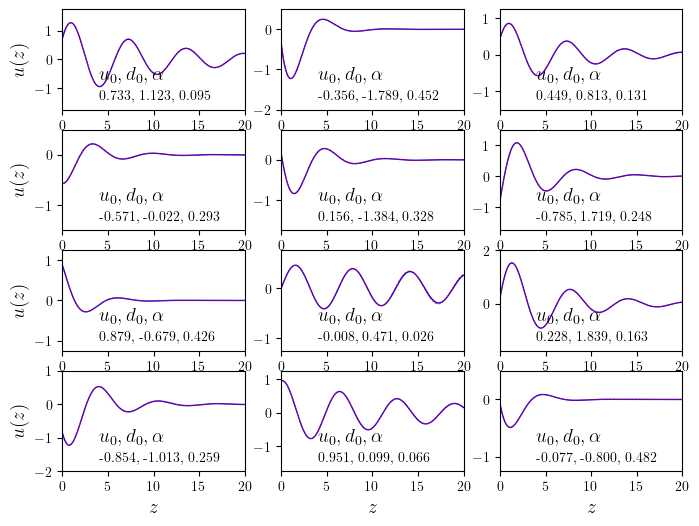

In [42]:
def plot_results(data, 
                 xmin=LOWER[0],  xmax=UPPER[0],
                 filename=PLOT_FILE,
                 fgsize=(8, 6), 
                 ftsize=14):

    plt.rcParams.update({'font.size': 10})

    # create an empty figure
    fig = plt.figure(figsize=fgsize)
    fig.tight_layout()

    # work out number of columns and number of plots
    ncols = 3
    nrows = len(data) // ncols
    ndata = nrows * ncols

    for i, (x, exact, approx, u0, d0, alpha) in enumerate(data):

        index = i+1
        ax  = fig.add_subplot(nrows, ncols, index)
        
        # setup x-axis
        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$z$', fontsize=ftsize)
        
        if i % ncols == 0:
            ax.set_ylabel(r'$u(z)$', fontsize=ftsize)

        # annotate plot
        dy = 0.25
        ymin = exact.min()
        n = int(np.abs(ymin)/dy)+4
        ymin = np.sign(ymin)*n*dy

        ymax = exact.max()
        n = int(np.abs(ymax)/dy)+2
        ymax = np.sign(ymax)*n*dy
        ax.set_ylim(ymin, ymax)

        xpos = xmin + 0.20 * (xmax-xmin)
        ypos = ymin + 0.30 * (ymax-ymin)
        ystep= (ymax-ymin)/5
        
        ax.text(xpos, ypos, r'$u_0, d_0, \alpha$', fontsize=14); ypos -= ystep
        ax.text(xpos, ypos, '%8.3f,%8.3f,%8.3f' % (u0, d0, alpha)); ypos -= ystep

        ax.plot(x, exact,  color='blue', linestyle='solid', linewidth=1.0)
        ax.plot(x, approx, color='red', linestyle='dashed', linewidth=0.5)
        
    plt.savefig(filename)
    #plt.show() # omit plt.show() to avoid launching window outside notebook

plot_results(data)